### Load all

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
os.chdir(os.path.abspath('..')) 

In [3]:
# My codes
import decoder_PC2d
# from model_viz6_functions import plot_samples 
import model_viz_functions_riab as modelviz_utils
import model_viz_loaders as modelviz_loaders
#########################################

import einops
import os

import jax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn

jax.config.parse_flags_with_absl()
jax.config.update("jax_numpy_rank_promotion", "raise")

import matplotlib.pyplot as plt
import joblib
# import pathlib
# import pickle


import ratinabox
from ratinabox.Neurons import PlaceCells
# from ratinabox.Agent import Agent

from dsm import datasets, envs, stade #, #train #metrics, console
# from dsm import plotting, rewards 
# from dsm.state import State
# from dsm.plotting import utils as plot_utils #fig_to_ndarray

[10:32:14] INFO     MUJOCO_GL is not set, so an OpenGL backend will be chosen automatically.         ]8;id=139468;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=5875;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#88\88]8;;\

           INFO     Successfully imported OpenGL backend: glfw                                       ]8;id=892149;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py\__init__.py]8;;\:]8;id=780449;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/_render/__init__.py#96\96]8;;\

           INFO     MuJoCo library version is: 2.3.7                                                 ]8;id=227180;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py\__init__.py]8;;\:]8;id=482239;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/dm_control/mujoco/wrapper/mjbindings/__init__.py#31\31]8;;\

/home/sruthi/Sruthi/dsm-hippocampus-main/dsm/stade.py:150: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  seed: int | jax.random.KeyArray | npr.SeedSequence | None,
/home/sruthi/Sruthi/dsm-hippocampus-main/dsm/stade.py:227: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  seed: int | jax.random.KeyArray | npr.SeedSequence | None = None,
/home/sruthi/Sruthi/dsm-hippocampus-main/dsm/train.py:119: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Arr

### ENV and MODEL path and CONFIGs here

In [4]:
ENVIRONMENT = "Ratinabox-v0-pc-random" 
model_path = "logdir-rat_50pc_random_walk" 

In [5]:
num_samples= 10 #config.plot_num_samples # Number of samples the model should generate

### Env and dataset

In [6]:
folder_dataset_path = os.path.dirname(datasets._DATASET_REGISTRY[ENVIRONMENT])
dataset = datasets.make_dataset(ENVIRONMENT)
# folder_dataset_path = "/media/sruthi/SSD2/sruthi_data/ratinaboxPCgoal/sac/"
# env_data_path = pathlib.Path(folder_dataset_path+"dataset.pkl")
# with env_data_path.open("rb") as fp:
#         dataset = pickle.load(fp)
# print(folder_dataset_path)
print("Dataset observations shape: ",dataset.observation.shape)
pc_path = folder_dataset_path+'/placecells_params.pkl'
log_file = folder_dataset_path+'/my_log.log'

env = envs.make(ENVIRONMENT)  #config.env
Ag = env.agent_lookup('agent_0')[0] # Agent(env) will create a new agent - agent0 already added in envs.py

PC_params = joblib.load(pc_path)
NUM_STATE_DIM_CELLS = PC_params['n']
print('NUM_STATE_DIM_CELLS:',NUM_STATE_DIM_CELLS)
PCs = PlaceCells(Ag, params=PC_params) 
# fig, ax = PCs.plot_rate_map(chosen_neurons="all")
env = stade.GymEnvWrapper(env, with_infos=False, seed=None)
# data = datasets.make_dataset(config.env)

Dataset observations shape:  (24000, 50)
NUM_STATE_DIM_CELLS: 50


In [7]:
# env = envs.make(ENVIRONMENT) 
# dir(env)

### Input xs - create dataset of place cell activations over the whole env

In [8]:
# env_coords = Ag.Environment.flattened_discrete_coords #(10000, 2)
env_coords = Ag.Environment.discretise_environment(dx=0.01) # dx=Ag.environment.scale/10 , dx=0.01
env_coords = env_coords.reshape(-1, env_coords.shape[-1])
# pc_full_env = PCs.get_state(evaluate_at="all").T # N of 10000 values corresponding to ag.Environment.flattened_discrete_coords # len 10000
pc_full_env = PCs.get_state(evaluate_at=None, pos=env_coords).T
pc_full_env.shape

(10000, 50)

### Decode position from PC activity

In [9]:
# dataset_positions = decoder_PC2d.simple_decode_position(dataset.observation,env_coords,pc_full_env,plot=True)
# # WORKS only when dx=0.01 in Ag.Environment.discretise_environment(dx=0.01) ?
# print(dataset_positions.shape)

/home/sruthi/Sruthi/dsm-hippocampus-main/decoder_PC2d.py:115: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')


positions_std [[0.010903   0.02272335]
 [0.00887818 0.01649038]
 [0.02509759 0.02721937]
 ...
 [0.0298487  0.01661886]
 [0.02536319 0.01474203]
 [0.0220177  0.0098829 ]]


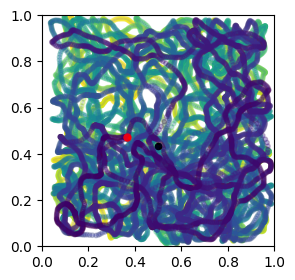

In [10]:
decoder_PC2d.train_xy_Net(PCs, Ag,epochs=50)
positions_all = decoder_PC2d.decode_position(PCs,dataset.observation,plot=True,method='dropoutNet')
positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,dataset.observation, method='dropoutNet',return_std=True)
print('positions_std',positions_std)

### Model stuff - restoring checkpoint

In [11]:
config, checkpoint_manager = modelviz_loaders.load_checkpointmgr_and_config_from_path(model_path, env)
# checkpoint_manager.all_steps() # returns list of step numbers [5000, 25000, ...]
# checkpoint_manager._checkpoints[1].step 

# state, config = modelviz_loaders.load_model_state_and_config_from_checkpoint_dir(model_path, env)
# print('Saved model state: Generator params shapes:',jax.tree_map(jnp.shape, state.generator.params))

# num_state_dims is the expected number of input place cells
# print(state.generator.apply_fn)  # MLP (num_layers = 3, num_hidden_units = 32, num_atoms = 10, num_state_dims = 50) #latent_dims = 5
# # print(state.generator.params['params']['model'].keys())   #  dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3'])
# # print(state.generator.params['params']['model']['Dense_3']['bias'].shape)  #n_outer, num_state_dims  

[10:32:30] WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=624923;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=599743;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

[10:32:31] INFO     Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered     ]8;id=12976;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=965377;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#660\660]8;;\
                    platform with name: "rocm". Available platform names are: CUDA                                 

           INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so:       ]8;id=640789;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=930838;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/jax/_src/xla_bridge.py#660\660]8;;\
                    libtpu.so: cannot open shared object file: No such file or directory                           

deleted  workdir


### Source states (100,50)

In [12]:
# source states to feed to the model
env_coords_small = Ag.Environment.discretise_environment(dx=0.05) # dx=Ag.environment.scale/10
# dx=0.05 , (400, 2)
#dx = 0.2, (25,2)
env_coords_small = env_coords_small.reshape(-1, env_coords.shape[-1])
# pc_full_env = PCs.get_state(evaluate_at="all").T # N of 10000 values corresponding to ag.Environment.flattened_discrete_coords # len 10000
source_states_env = PCs.get_state(evaluate_at=None, pos=env_coords_small).T
print(source_states_env.shape)
# plt.plot(env_coords_small[:,0],env_coords_small[:,1],'o')
# plt.ylim(0, 1)
# plt.xlim(0, 1)

unique_xpos, indices = np.unique(env_coords_small[:, 0], return_index=True)
xpos = unique_xpos[np.argsort(indices)]
unique_ypos, indices = np.unique(env_coords_small[:, 1], return_index=True)
ypos = unique_ypos[np.argsort(indices)]

# positions_all = decoder_PC2d.decode_position(PCs,source_states_env,plot=True)
# source_states_env_PCactivities = decoder_PC2d.simple_decode_position(source_states_env, env_coords, pc_full_env,plot=False)


######################################
gaussian_PC_fullenv = PCs.get_state(evaluate_at= None, pos = env_coords_small ) # evaluate_at= "all"
gaussian_PC_fullenv.shape

# neuron0_rate_map = gaussian_PC_fullenv[0,:].reshape(Ag.Environment.discrete_coords.shape[:2]
#                         )
# neuron0_rate_map.shape # (100,100)
# # modelviz_utils.plot_neuron_activations(source_states_env,0,'true rate map of PC 1',xpos,ypos)
# # modelviz_utils.plot_neuron_activations(gaussian_PC_fullenv.T,0,'true rate map of PC 1',xpos,ypos)
# # PCs.plot_rate_map(chosen_neurons='1')

(400, 50)


(50, 400)

## Show plots across checkpoints 
- how model learns 
- euclidean similarity across 20 checkpoints for 10 atoms - 50 PCs (Dense3 activations? or outputs basically- no need of internals) 

1. Choose random sources - plot (also checks if any decoded positions fall outside the bounds of env - those atoms may not be trained well?)
2. Choose atom 0 - (or atom with least max SD with final checkpoint)
- load 20 models and generate the 50 rate maps ? with same latent

- effect of different latents ?? change jax.random.PRNGKey(0) in modelviz_utils.compute_DSM_samples_single_source
- different atoms outputs as compared to original ratemaps ? ( some atoms give high SD for decoding location for different sources)

- model internals 
- plot by direction of travel - rayleigh vector


atom_input = latent+source_state

DSM model input (n_samples, n_atoms, atom_input)

### compute DSM samples

In [13]:
checkpoint_manager.all_steps()


[25000,
 50000,
 75000,
 100000,
 125000,
 150000,
 175000,
 200000,
 225000,
 250000,
 275000,
 300000,
 325000,
 350000,
 375000,
 400000,
 425000,
 450000,
 475000,
 500000]

#### comparing first and last checkpoint with same source and latent

In [14]:
# check if any atoms have high uncertainty with random sources - WITH FINAL CHECKPOINT
state_final, config = modelviz_loaders.load_model_state_and_config_from_checkpoint_dir(model_path, env)
state_0, config = modelviz_loaders.load_model_state_and_config_from_checkpoint_dir(model_path, env,checkpoint_step = checkpoint_manager.all_steps()[0])

[10:32:33] WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=380840;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=947753;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir
debug latest_step 500000


[10:32:36] INFO     Restoring item from                                                         ]8;id=987046;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=34572;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/500000                    
                    .                                                                                              

/home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1464: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs.
  warnings.warn(


           INFO     Finished restoring checkpoint from                                          ]8;id=977316;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=878242;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/500000                    
                    .                                                                                              

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=846069;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=742083;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


[10:32:37] INFO     Restoring item from                                                         ]8;id=633028;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=804684;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/25000.                    

           INFO     Finished restoring checkpoint from                                          ]8;id=226402;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=345287;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/25000.                    

In [15]:
random_sources = np.random.randint(0,source_states_env.shape[0],size=5)
latent_rng = jax.random.PRNGKey(0)

source pos:  [0.775 0.025]
Max SD of samples decoded with dropoutNet: (0.12237656, 0.12431262) ; Atom 0
Max SD of samples decoded with dropoutNet: (0.15771098, 0.14437719) ; Atom 2
Max SD of samples decoded with dropoutNet: (0.12094402, 0.15475586) ; Atom 3
Max SD of samples decoded with dropoutNet: (0.20067622, 0.16692777) ; Atom 4
Max SD of samples decoded with dropoutNet: (0.10633835, 0.13407545) ; Atom 5
Max SD of samples decoded with dropoutNet: (0.14459631, 0.11688773) ; Atom 9
decoded source:  [0.7802312  0.03585252]


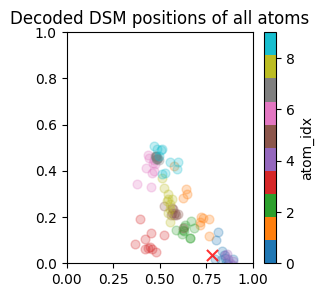

source pos:  [0.025 0.325]
Max SD of samples decoded with dropoutNet: (0.15227365, 0.10909386) ; Atom 1
decoded source:  [0.06754553 0.35409072]


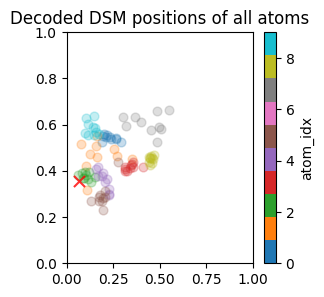

source pos:  [0.925 0.625]
Max SD of samples decoded with dropoutNet: (0.18352212, 0.11734122) ; Atom 4
Max SD of samples decoded with dropoutNet: (0.11255041, 0.121806405) ; Atom 9
decoded source:  [0.91770273 0.6224045 ]


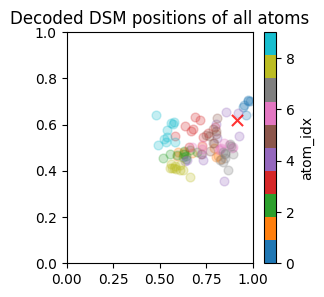

source pos:  [0.225 0.875]
Max SD of samples decoded with dropoutNet: (0.11611866, 0.16302332) ; Atom 3
Max SD of samples decoded with dropoutNet: (0.14679122, 0.11697811) ; Atom 6
decoded source:  [0.2406396 0.8735033]


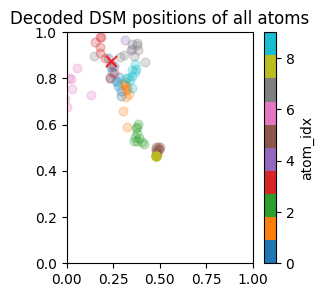

source pos:  [0.775 0.575]
Max SD of samples decoded with dropoutNet: (0.18694447, 0.16184741) ; Atom 4
decoded source:  [0.77111566 0.58142614]


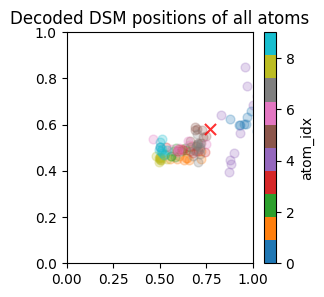

In [16]:
# FIRST CHECKPOINT
for source_idx in random_sources:
    source=source_states_env[source_idx]
    print('source pos: ',env_coords_small[source_idx])
    source, samples = modelviz_loaders.compute_DSM_samples_single_source(
            state_0.generator, latent_rng, config=config, source_state_current=source, num_samples = num_samples
        )
    modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=False,atom='all',method='dropoutNet')
    

source pos:  [0.775 0.025]
Max SD of samples decoded with dropoutNet: (0.109949484, 0.12438484) ; Atom 0
Max SD of samples decoded with dropoutNet: (0.10503735, 0.13700487) ; Atom 1
Max SD of samples decoded with dropoutNet: (0.24407656, 0.20083772) ; Atom 9
decoded source:  [0.7802312  0.03585252]


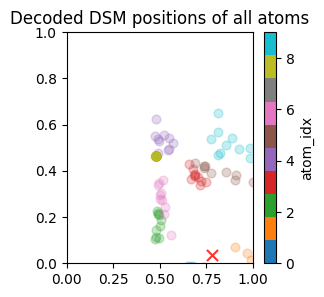

source pos:  [0.025 0.325]
Max SD of samples decoded with dropoutNet: (0.24902767, 0.15776145) ; Atom 4
Max SD of samples decoded with dropoutNet: (0.21059757, 0.1840513) ; Atom 9
decoded source:  [0.06754553 0.35409072]


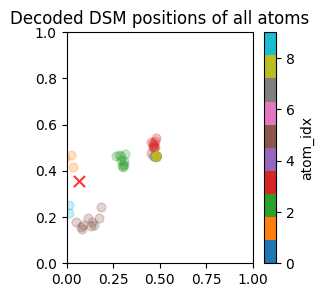

source pos:  [0.925 0.625]
Max SD of samples decoded with dropoutNet: (0.13411744, 0.1442083) ; Atom 2
Max SD of samples decoded with dropoutNet: (0.52545476, 0.37714714) ; Atom 9
decoded source:  [0.91770273 0.6224045 ]


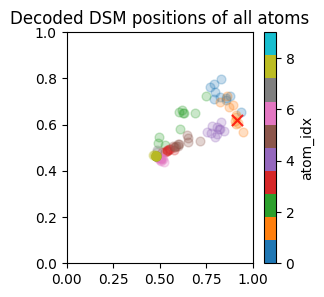

source pos:  [0.225 0.875]
Max SD of samples decoded with dropoutNet: (0.1017643, 0.17645966) ; Atom 1
Max SD of samples decoded with dropoutNet: (0.19717254, 0.24982832) ; Atom 4
Max SD of samples decoded with dropoutNet: (0.1200023, 0.13327701) ; Atom 6
Max SD of samples decoded with dropoutNet: (0.47324812, 0.7499775) ; Atom 7
Max SD of samples decoded with dropoutNet: (0.13572463, 0.1258163) ; Atom 9
decoded source:  [0.2406396 0.8735033]


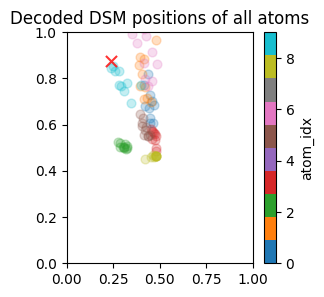

source pos:  [0.775 0.575]
Max SD of samples decoded with dropoutNet: (0.12364649, 0.16640507) ; Atom 2
Max SD of samples decoded with dropoutNet: (0.4316385, 0.2822264) ; Atom 9
decoded source:  [0.77111566 0.58142614]


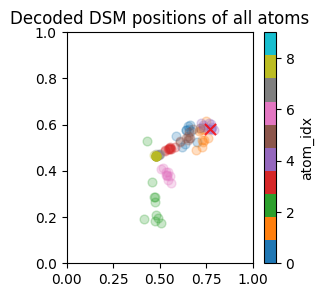

Max SD of decoded samples of atom 2 with dropoutNet: (0.10764452, 0.13318695)
Max SD of decoded samples of atom 9 with dropoutNet: (0.4216329, 0.30712777)


In [17]:
# FINAL CHECKPOINT
for source_idx in random_sources:
    source=source_states_env[source_idx]
    print('source pos: ',env_coords_small[source_idx])
    source, samples = modelviz_loaders.compute_DSM_samples_single_source(
            state_final.generator, latent_rng, config=config, source_state_current=source, num_samples = num_samples
        )
    modelviz_utils.plot_samples(PCs, dataset.observation,samples,source, make_dataset=False,atom='all',method='dropoutNet')

atom_idx_values = np.arange(10) #[3,4,8]
for atom_idx in atom_idx_values:
    positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[atom_idx], method='dropoutNet',return_std=True)
    maxc1, maxc2 = np.max(positions_std[:, 0]), np.max(positions_std[:, 1])
    if maxc1 > 0.1 and maxc2 > 0.1:
        print(f'Max SD of decoded samples of atom {atom_idx} with dropoutNet: {maxc1, maxc2}')
        
# atom_idx = 2
# positions_pred, positions_std  = decoder_PC2d.decode_position(PCs,samples[atom_idx], method='dropoutNet',return_std=True)
# print(f'SD of decoded samples with dropoutNet:{positions_std}')

#### ALL CKPTS - load

In [18]:
model_states_all = []
num_ckpts = len(checkpoint_manager.all_steps()) 
for ckpt_idx in range(num_ckpts):
    state_current, config = modelviz_loaders.load_model_state_and_config_from_checkpoint_dir(model_path, env,
                                                                checkpoint_step = checkpoint_manager.all_steps()[ckpt_idx])
    model_states_all.append(state_current)

[10:32:40] WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=192521;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=192569;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=902507;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=584312;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/25000.                    

           INFO     Finished restoring checkpoint from                                          ]8;id=192212;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=902913;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/25000.                    

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=226245;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=947508;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=82679;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=125006;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/50000.                    

[10:32:41] INFO     Finished restoring checkpoint from                                          ]8;id=255817;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=267674;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/50000.                    

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=2848;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=926675;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=551387;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=298497;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/75000.                    

           INFO     Finished restoring checkpoint from                                          ]8;id=733992;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=377697;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/75000.                    

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=870238;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=742831;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=589563;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=546098;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/100000                    
                    .                                                                                              

           INFO     Finished restoring checkpoint from                                          ]8;id=309035;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=183755;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/100000                    
                    .                                                                                              

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=485042;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=103634;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


[10:32:42] INFO     Restoring item from                                                         ]8;id=336639;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=833595;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/125000                    
                    .                                                                                              

           INFO     Finished restoring checkpoint from                                          ]8;id=702311;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=308165;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/125000                    
                    .                                                                                              

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=814010;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=875421;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=209360;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=654740;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/150000                    
                    .                                                                                              

           INFO     Finished restoring checkpoint from                                          ]8;id=149136;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=558196;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/150000                    
                    .                                                                                              

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=404821;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=529564;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=8518;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=160571;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/175000                    
                    .                                                                                              

           INFO     Finished restoring checkpoint from                                          ]8;id=584825;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=375846;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/175000                    
                    .                                                                                              

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=378206;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=635849;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


[10:32:43] INFO     Restoring item from                                                         ]8;id=276899;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=152563;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/200000                    
                    .                                                                                              

           INFO     Finished restoring checkpoint from                                          ]8;id=573284;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=260768;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/200000                    
                    .                                                                                              

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=180021;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=62049;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=210635;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=581438;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/225000                    
                    .                                                                                              

           INFO     Finished restoring checkpoint from                                          ]8;id=998325;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=659399;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/225000                    
                    .                                                                                              

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=983859;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=707451;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=808588;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=520238;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/250000                    
                    .                                                                                              

           INFO     Finished restoring checkpoint from                                          ]8;id=195469;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=83941;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/250000                    
                    .                                                                                              

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=613567;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=89468;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


[10:32:44] INFO     Restoring item from                                                         ]8;id=398694;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=57163;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/275000                    
                    .                                                                                              

           INFO     Finished restoring checkpoint from                                          ]8;id=844072;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=726138;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/275000                    
                    .                                                                                              

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=414774;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=344519;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=730316;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=362111;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/300000                    
                    .                                                                                              

           INFO     Finished restoring checkpoint from                                          ]8;id=814838;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=457535;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/300000                    
                    .                                                                                              

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=197467;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=945210;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=124127;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=886736;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/325000                    
                    .                                                                                              

           INFO     Finished restoring checkpoint from                                          ]8;id=714868;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=990912;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/325000                    
                    .                                                                                              

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=599544;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=783588;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=922930;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=98430;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/350000                    
                    .                                                                                              

[10:32:45] INFO     Finished restoring checkpoint from                                          ]8;id=897126;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=554244;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/350000                    
                    .                                                                                              

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=957698;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=600665;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=345323;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=71628;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/375000                    
                    .                                                                                              

           INFO     Finished restoring checkpoint from                                          ]8;id=77698;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=244140;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/375000                    
                    .                                                                                              

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=489686;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=624546;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=276921;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=238177;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/400000                    
                    .                                                                                              

           INFO     Finished restoring checkpoint from                                          ]8;id=566917;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=829923;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/400000                    
                    .                                                                                              

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=859860;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=229134;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=489097;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=210952;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/425000                    
                    .                                                                                              

           INFO     Finished restoring checkpoint from                                          ]8;id=247833;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=384345;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/425000                    
                    .                                                                                              

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=786331;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=694365;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


[10:32:46] INFO     Restoring item from                                                         ]8;id=231001;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=924849;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/450000                    
                    .                                                                                              

           INFO     Finished restoring checkpoint from                                          ]8;id=704332;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=412287;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/450000                    
                    .                                                                                              

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=130499;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=9728;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=42773;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=726806;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/475000                    
                    .                                                                                              

           INFO     Finished restoring checkpoint from                                          ]8;id=67657;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=271443;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/475000                    
                    .                                                                                              

           WARNING  Configured `CheckpointManager` using deprecated legacy API. Please    ]8;id=116594;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py\checkpoint_manager.py]8;;\:]8;id=969884;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpoint_manager.py#422\422]8;;\
                    follow the instructions at                                                                     
                    https://orbax.readthedocs.io/en/latest/api_refactor.html to migrate                            
                    by May 1st, 2024.                                                                              

deleted  workdir


           INFO     Restoring item from                                                         ]8;id=284008;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=230170;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#164\164]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/500000                    
                    .                                                                                              

           INFO     Finished restoring checkpoint from                                          ]8;id=285511;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py\checkpointer.py]8;;\:]8;id=963368;file:///home/sruthi/Sruthi/.venv/lib/python3.10/site-packages/orbax/checkpoint/checkpointer.py#167\167]8;;\
                    /home/sruthi/Sruthi/dsm-hippocampus-main/logdir-rat_50pc_random_walk/500000                    
                    .                                                                                              

#### for ALL CKPTS: choose 1 atom (/10) and 1 latent
- but different atoms?
- different latents for same atom?

In [19]:
# (env divided into 100 xy positions: INPUT DIM (55) - PC activity dim 50 + fixed LATENT STATE(dim 5)

#TODO - select atom
atom_num = 4  # ith atom
print('Atom: ',atom_num)
rng_seed = 0 # FIXED LATENT STATE SEED
zs = jax.random.normal(jax.random.PRNGKey(rng_seed), (config.latent_dims,))
print('zs ',zs)

Atom:  4
zs  [ 0.18784384 -1.2833426  -0.2710917   1.2490593   0.24447003]


#### Dense 3 activations correspond to output - should look like place cell ratemaps 

In [20]:
print(f' Input sources: {source_states_env.shape[0]}, PCs: {source_states_env.shape[1]}')

 Input sources: 400, PCs: 50


In [21]:
#TODO - select layer
layers = ['Dense_3',]
# Plot intermediate activations as 2D maps

activations_layer_1atom_allckpts = [] # of length num_ckpts
for i,state_current in enumerate(model_states_all):
    print(f'Checkpoint:{i+1}/{num_ckpts} - Step: {checkpoint_manager.all_steps()[i]} - Atom: {atom_num} - layer: {layers}')
    model_generator = state_current.generator
    atom_params = modelviz_loaders.extract_params_ith_atom(model_generator, atom_num, config.num_outer )

    activations_layer = modelviz_utils.compute_activation_layer_all_sources(model_generator, atom_params, source_states_env,zs, layers)
    # print('activations_layer shape:',activations_layer.shape) #(100,50) for Dense_3
    activations_layer_1atom_allckpts.append(activations_layer)

Checkpoint:1/20 - Step: 25000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:2/20 - Step: 50000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:3/20 - Step: 75000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:4/20 - Step: 100000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:5/20 - Step: 125000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:6/20 - Step: 150000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:7/20 - Step: 175000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:8/20 - Step: 200000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:9/20 - Step: 225000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:10/20 - Step: 250000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:11/20 - Step: 275000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:12/20 - Step: 300000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:13/20 - Step: 325000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:14/20 - Step: 350000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:15/20 - Step: 375000 - Atom: 4 - layer: ['Dense_3']
Checkpoint:16/20 - Step: 400000 - Atom: 4 - layer: ['Dense_3']
Chec

In [22]:
# import importlib
# importlib.reload(modelviz_utils)

Atom: 4 - Layer: ['Dense_3'] - Neuron: 0


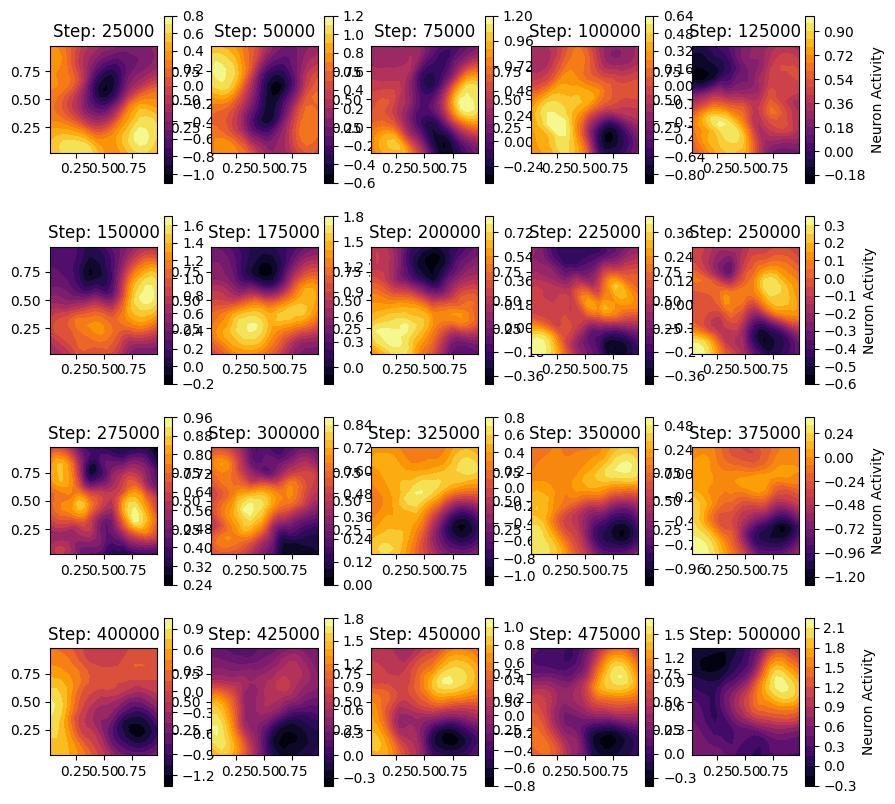

In [23]:
neuron_idx=0 # neuron_idx = 'all' or some int in range(0,9) 
print(f'Atom: {atom_num} - Layer: {layers} - Neuron: {neuron_idx}')

# Determine the number of rows and columns for the subplots
n = len(activations_layer_1atom_allckpts)
cols = 5
rows = n // cols
rows += n % cols
position = range(1,n + 1)
# Create the subplots
fig = plt.figure(figsize=(10, 10))

for k, activations_layer in enumerate(activations_layer_1atom_allckpts): 
    ax = fig.add_subplot(rows, cols, position[k])
    figlabel = f'Step: {checkpoint_manager.all_steps()[k]}'
    modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx,xpos,ypos, figlabel, ax_main=ax)

# Display the plot
plt.show()


# neuron_idx=0 # neuron_idx = 'all' or some int in range(0,9) 
# print('Plotting neuron:',neuron_idx)
# for i,activations_layer in enumerate(activations_layer_1atom_allckpts[:3]): 
#     figlabel = f'Step: {checkpoint_manager.all_steps()[i]} - Atom: {atom_num} - Layer: {layers} - Neuron: {neuron_idx}'
#     modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx,xpos,ypos, figlabel)

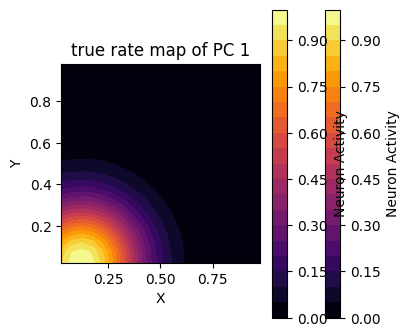

    • To AUTOMATICALLY save all plots (recommended), set  `ratinabox.autosave_plots = True`
    • To MANUALLY save plots, call                        `ratinabox.utils.save_figure(figure_object, save_title).
      This warning will not be shown again
HINT: You can stylize plots to make them look like repo/paper by calling `ratinabox.stylize_plots()`
      This hint will not be shown again


(<Figure size 250x250 with 2 Axes>, array([<Axes: >], dtype=object))

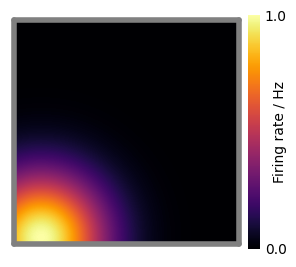

In [25]:
# modelviz_utils.plot_neuron_activations(source_states_env,0,'true rate map of PC 1',xpos,ypos)
modelviz_utils.plot_neuron_activations(gaussian_PC_fullenv.T,0,xpos,ypos,'true rate map of PC 1',)
PCs.plot_rate_map(chosen_neurons='1')


#### Similarity for PC rate maps across ckpts

In [26]:
import importlib 
importlib.reload(modelviz_utils)

<module 'model_viz_functions_riab' from '/home/sruthi/Sruthi/dsm-hippocampus-main/model_viz_functions_riab.py'>

In [27]:
print('Atom: {atom_num} - Layer: {layers} - Neuron: {neuron_idx}')
neuron_list = [0] #np.arange(activations_neuron.shape[-1])
ckpt_step_nums = checkpoint_manager.all_steps()

# from each ckpt to true rate map
# modelviz_utils.compute_distance_similarity_with_trueratemap( gaussian_PC_fullenv, activations_layer_1atom_allckpts,
#                                                             ckpt_step_nums,neuron_list,metric='euclidean')
# modelviz_utils.compute_distance_similarity_with_trueratemap( gaussian_PC_fullenv, activations_layer_1atom_allckpts,
#                                                             ckpt_step_nums,neuron_list,metric='cosine')
# from one ckpt to next
modelviz_utils.compute_distance_similarity(activations_layer_1atom_allckpts, ckpt_step_nums, neuron_list, metric='euclidean')
modelviz_utils.compute_distance_similarity(activations_layer_1atom_allckpts, ckpt_step_nums, neuron_list, metric='cosine')

Atom: {atom_num} - Layer: {layers} - Neuron: {neuron_idx}
Neuron:  0
Ckpt Step: 25000 - 50000:                   euclidean score: 9.965867
Ckpt Step: 50000 - 75000:                   euclidean score: 7.805007
Ckpt Step: 75000 - 100000:                   euclidean score: 10.157262
Ckpt Step: 100000 - 125000:                   euclidean score: 10.026244
Ckpt Step: 125000 - 150000:                   euclidean score: 9.586887
Ckpt Step: 150000 - 175000:                   euclidean score: 6.230027
Ckpt Step: 175000 - 200000:                   euclidean score: 13.206636
Ckpt Step: 200000 - 225000:                   euclidean score: 7.3560085
Ckpt Step: 225000 - 250000:                   euclidean score: 2.842639
Ckpt Step: 250000 - 275000:                   euclidean score: 13.582601
Ckpt Step: 275000 - 300000:                   euclidean score: 4.4715796
Ckpt Step: 300000 - 325000:                   euclidean score: 8.961576
Ckpt Step: 325000 - 350000:                   euclidean score: 6.0

In [37]:
print('Atom: {atom_num} - Layer: {layers} - Neuron: {neuron_idx}')
neuron_list = [0] #np.arange(activations_neuron.shape[-1])
ckpt_step_nums = checkpoint_manager.all_steps()

normalized_activations_layer_1atom_allckpts = []
for activations in activations_layer_1atom_allckpts:
    min_val = np.amin(activations, axis=0)
    max_val = np.amax(activations, axis=0)
    activations_normalized = (activations - min_val) / (max_val - min_val)
    normalized_activations_layer_1atom_allckpts.append(activations_normalized)

# from each ckpt to original Gaussian PC rate map
modelviz_utils.compute_distance_similarity_with_trueratemap( gaussian_PC_fullenv, normalized_activations_layer_1atom_allckpts,
                                                            ckpt_step_nums,neuron_list,metric='euclidean')
modelviz_utils.compute_distance_similarity_with_trueratemap( gaussian_PC_fullenv, normalized_activations_layer_1atom_allckpts,
                                                            ckpt_step_nums,neuron_list,metric='cosine')
# modelviz_utils.compute_distance_similarity(activations_layer_1atom_allckpts,ckpt_step_nums,neuron_list,metric='euclidean')
# modelviz_utils.compute_distance_similarity(activations_layer_1atom_allckpts,ckpt_step_nums,neuron_list,metric='cosine')


Atom: {atom_num} - Layer: {layers} - Neuron: {neuron_idx}
Neuron:  0
Ckpt Step: 25000: euclidean score: 10.698100392531861
Ckpt Step: 50000: euclidean score: 10.2765921905052
Ckpt Step: 75000: euclidean score: 8.300249039065365
Ckpt Step: 100000: euclidean score: 10.709430545762464
Ckpt Step: 125000: euclidean score: 8.93503841472711
Ckpt Step: 150000: euclidean score: 9.801080259603035
Ckpt Step: 175000: euclidean score: 10.345276659166137
Ckpt Step: 200000: euclidean score: 9.930107401739793
Ckpt Step: 225000: euclidean score: 8.484554550289163
Ckpt Step: 250000: euclidean score: 10.545605618049866
Ckpt Step: 275000: euclidean score: 9.972412754736672
Ckpt Step: 300000: euclidean score: 9.792745513645228
Ckpt Step: 325000: euclidean score: 13.312854403421893
Ckpt Step: 350000: euclidean score: 12.190194192695154
Ckpt Step: 375000: euclidean score: 11.150426729602389
Ckpt Step: 400000: euclidean score: 10.152708804872267
Ckpt Step: 425000: euclidean score: 7.135012579977712
Ckpt Step:

Plotting neuron: 0


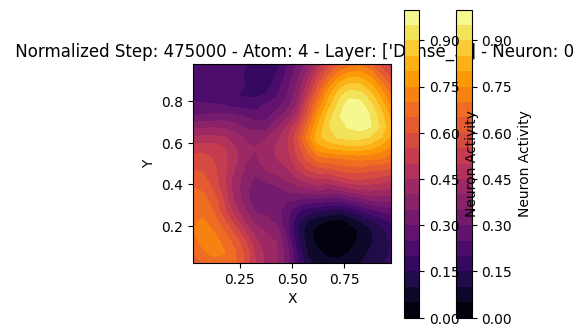

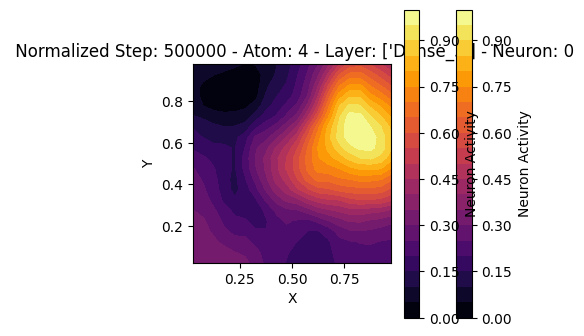

In [38]:
neuron_idx=0 # neuron_idx = 'all' or some int in range(0,9) 
print('Plotting neuron:',neuron_idx)
for i,activations_layer in enumerate(normalized_activations_layer_1atom_allckpts[-2:]): 
    figlabel = f' Normalized Step: {checkpoint_manager.all_steps()[-2:][i]} - Atom: {atom_num} - Layer: {layers} - Neuron: {neuron_idx}'
    modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx,xpos,ypos, figlabel)


Plotting neuron: all


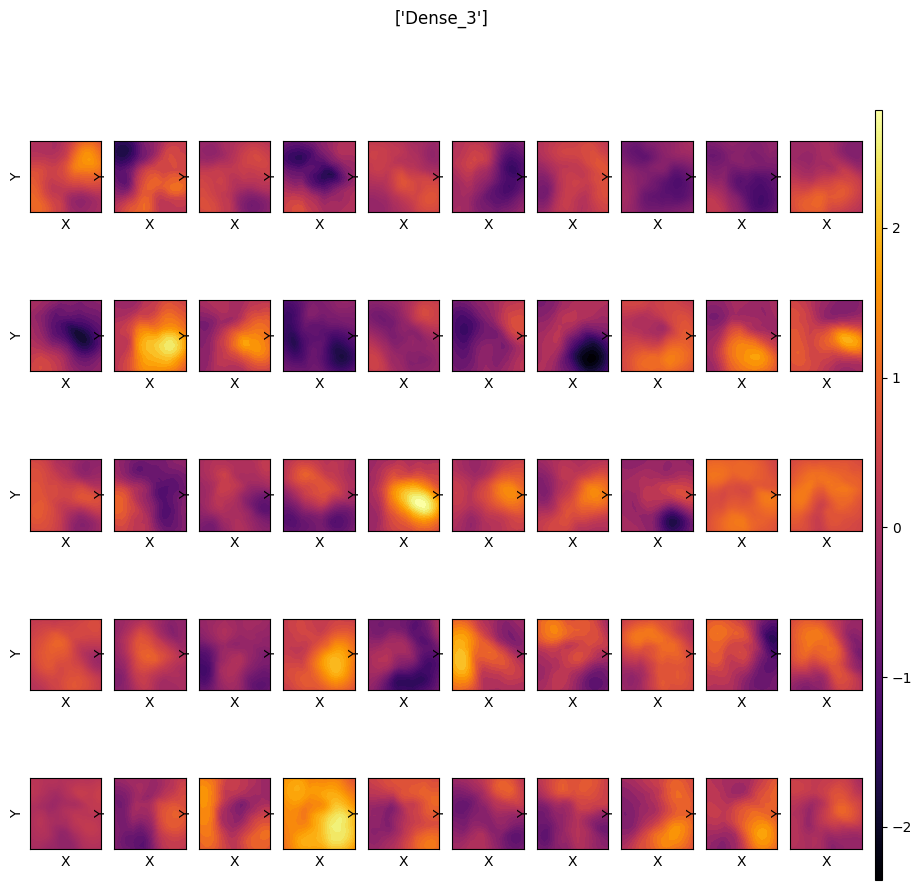

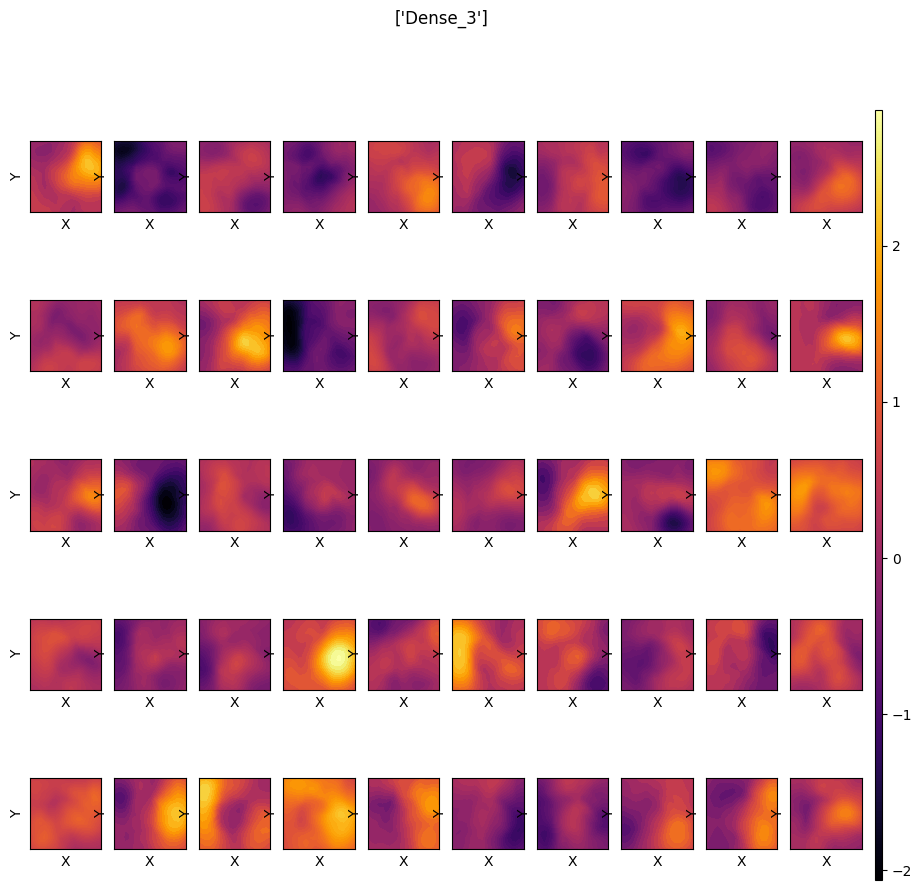

In [40]:
neuron_idx='all' # neuron_idx = 'all' or some int in range(0,9) 
print('Plotting neuron:',neuron_idx)
for i,activations_layer in enumerate(activations_layer_1atom_allckpts[-2:]):
    modelviz_utils.plot_neuron_activations(activations_layer,neuron_idx,xpos,ypos,layers)

In [29]:
# DIFFERENT LATENTS
# - later try all latent dim 5 having same values?
# - see which neurons dont change much with latent state ?

# activations_neurons_randomz = []
# for rng_seed in range(3):
#     zs = jax.random.normal(jax.random.PRNGKey(rng_seed), (config.latent_dims,))
#     print('zs',zs)
#     activations_neurons = modelviz_utils.compute_activation_layer_all_sources(model_generator,atom_params, source_states_env,zs, layers)
#     activations_neurons_randomz.append(activations_neurons)
# for i in range(len(activations_neurons_randomz)):
#     neuron_idx = np.arange(activations_neurons_randomz[i].shape[-1])
#     modelviz_utils.plot_neuron_activations(activations_neurons_randomz[i],neuron_idx,layers,xpos,ypos)

In [30]:
# layers = ['Dense_2',]
# layers = ['Dense_1',]
# layers = ['Dense_0',]

In [31]:
### All intermediates
# #TODO - select layer
# layers = ['Dense_0','Dense_1','Dense_2','Dense_3']
# rng = jax.random.PRNGKey(0)
# zs = jax.random.normal(rng, (config.latent_dims,))
# # zs = jax.random.normal(rng, (config.batch_size, config.num_inner, config.num_outer, config.latent_dims))
# activations_alllayers = modelviz_utils.compute_activation_allintermediates_all_sources(model_generator, atom_params, source_states_env, zs, layers)
# # print(activations_alllayers['Dense_0'] )
# # joblib.dump(activations_alllayers, model_path+f'/activations_alllayers_latent_atom{atom_i}.pkl')
# # activations_alllayers = joblib.load('activations_alllayers_latent_atom{atom_i}.pkl')

### Different atom

In [32]:
# i = 4  # ith atom
# layers = ['Dense_3',]
# sel_neuron_idx=0 # neuron_idx = np.arange(activations_neurons.shape[-1])
# random_seed = 0

# atom_params = modelviz_loaders.extract_params_ith_atom(state.generator, i, config.num_outer )
# zs = jax.random.normal(jax.random.PRNGKey(random_seed), (config.latent_dims,))
# activations_neurons = modelviz_utils.compute_activation_layer_all_sources(model_generator, atom_params, source_states_env,zs, layers)
# print(activations_neurons.shape)
# modelviz_utils.plot_neuron_activations(activations_neurons,neuron_idx,layers,xpos,ypos)

## Later

- decoding from hidden neuron to start and end state, 
- tsne/ umap
- entropy

Model will generate different successor states from the same source state (effect of different latents?, try giving all 5 same?). \
Different source states may generate same successor states (same x,y positions) 

xs[:,:,-3:] #same - context - source state , rest noise latent dims  \
 xs_atom #shape (8)

In [33]:
# from model_viz6_functions import show_allsamples_compute_activation_layer_all_sources, plot_neuron_activations_samples

# num_samples=7 #config.plot_num_samples # Number of state samples 
# print(f' using {num_samples} samples')
# layers = ['Dense_3',]  # # layer 3 activations are predicted states
# activations_layer = show_allsamples_compute_activation_layer_all_sources(model_generator, atom_params, source_states_env, layers,num_samples,config.latent_dims)
# print(activations_layer.shape)
# assert activations_layer.shape[-1] == 50
# neuron_idx = 2
# label=f'Activations of neuron {neuron_idx} of  {layers} all generated samples'
# plot_neuron_activations_samples(activations_layer,neuron_idx,label,xpos, ypos)

# source_idx = 10
# plt.scatter(x[source_idx], y[source_idx], marker="x", color="red")
# predicted_states = activations_layer[ source_idx,:, :]
# decode x and y position from predicted PC activations
# plt.scatter(x_pred, y_pred)